In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import os
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# read the data

In [133]:
gas = pd.read_excel("data.xlsx", sheet_name="gas prices")
elec = pd.read_excel("data.xlsx", sheet_name="electricity prices")
hs = pd.read_excel("data.xlsx", sheet_name="household spending")

# gas price prediction

## Exploratory Data Analysis

In [134]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044 entries, 0 to 2043
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    2044 non-null   datetime64[ns]
 1   SAP actual day
(p/kWh)  2044 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 32.1 KB


In [135]:
gas.columns

Index(['Date', 'SAP actual day\n(p/kWh)'], dtype='object')

In [136]:
data = gas.copy()
# Renaming columns
data = data.rename({'Date': 'date', 'SAP actual day\n(p/kWh)': 'gas_price'}, axis = 1)

# Setting Date as index
data = data.set_index('date')

In [137]:
# Finding the missing data
print(data.isnull().sum())

gas_price    0
dtype: int64


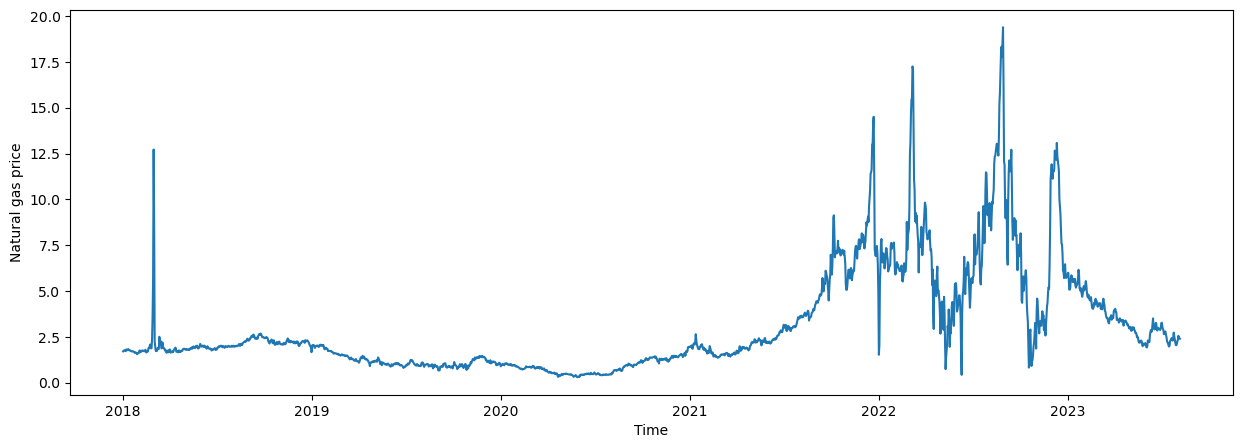

In [138]:
plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.plot(data);


## build lstm model

In [139]:
def build_model(num_layers, slot, dp1, dp2, unit1, unit2, unit3):
    lstm_model = tf.keras.Sequential()
    lstm_model.add(tf.keras.layers.LSTM(units = unit1, input_shape = (slot, 1), return_sequences = True, activation = 'relu'))
    lstm_model.add(tf.keras.layers.Dropout(dp1))
    for i in range(num_layers):
        lstm_model.add(tf.keras.layers.LSTM(units = unit2, activation = 'relu', return_sequences = True))
        # lstm_model.add(tf.keras.layers.Dropout(0.01))
    lstm_model.add(tf.keras.layers.LSTM(units = unit3, return_sequences = False))
    lstm_model.add(tf.keras.layers.Dropout(dp2))
    lstm_model.add(tf.keras.layers.Dense(units = 1))
    return lstm_model

In [140]:
### build dataset

In [141]:
def build_data(data, slot=15):
    n  = len(data)
    train_n = int(np.ceil(n*0.8))
    train = data.iloc[:train_n]
    test = data.iloc[train_n:]
    
    x_train = []
    y_train = []
    
    for i in range(slot, len(train)):
        x_train.append(train.iloc[i-slot:i, 0])
        y_train.append(train.iloc[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    
    dataset_total = pd.concat((train, test), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(test)- slot:].values
    inputs = inputs.reshape(-1, 1)
    
    x_test = []
    y_test = []
    for i in range (slot, len(test)+slot): #Test+15
        x_test.append(inputs[i-slot:i, 0])
        y_test.append(train.iloc[i, 0])
          
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    return train, test, x_train, y_train, x_test, y_test

### build and train the model

In [142]:
slot=15
lstm_model = build_model(num_layers=2, slot=slot,  dp1=0.01, dp2=0.01, unit1=50, unit2=50, unit3=50)
lstm_model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005))
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 15, 50)            10400     
                                                                 
 dropout_10 (Dropout)        (None, 15, 50)            0         
                                                                 
 lstm_23 (LSTM)              (None, 15, 50)            20200     
                                                                 
 lstm_24 (LSTM)              (None, 15, 50)            20200     
                                                                 
 lstm_25 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [143]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)

train, test, x_train, y_train, x_test, y_test = build_data(data,slot=slot)
#history = lstm_model.fit(x_train, y_train, epochs = 100, 
#                         batch_size = 10, 
#                         verbose = 1, shuffle = True, 
#                         callbacks = [early_stopping])
history = lstm_model.fit(x_train, y_train, epochs =45, 
                         batch_size = 10, 
                         verbose = 1, shuffle = True)

Epoch 1/45
163/163 [==============================] - 15s 20ms/step - loss: 2.5868
Epoch 2/45
163/163 [==============================] - 3s 21ms/step - loss: 0.8999
Epoch 3/45
163/163 [==============================] - 3s 18ms/step - loss: 0.8352
Epoch 4/45
163/163 [==============================] - 3s 18ms/step - loss: 0.7261
Epoch 5/45
163/163 [==============================] - 4s 21ms/step - loss: 0.7058
Epoch 6/45
163/163 [==============================] - 4s 23ms/step - loss: 0.6393
Epoch 7/45
163/163 [==============================] - 3s 21ms/step - loss: 0.5758
Epoch 8/45
163/163 [==============================] - 3s 18ms/step - loss: 0.5247
Epoch 9/45
163/163 [==============================] - 3s 18ms/step - loss: 0.4861
Epoch 10/45
163/163 [==============================] - 3s 18ms/step - loss: 0.4633
Epoch 11/45
163/163 [==============================] - 3s 20ms/step - loss: 0.4288
Epoch 12/45
163/163 [==============================] - 3s 17ms/step - loss: 0.3752
Epoch 13/45


### evalute the model

In [144]:
# predict on train set
yp_train = lstm_model.predict(x_train)
a = pd.DataFrame(yp_train)
a.rename(columns = {0: 'pred'}, inplace = True); 
a.index = train.iloc[slot:].index
train_compare = pd.concat([train.iloc[slot:], a], axis=1)

# predict on test set
pred = lstm_model.predict(x_test)
b = pd.DataFrame(pred)
b.rename(columns = {0: 'pred'}, inplace = True); 
b.index = test.index
test_compare = pd.concat([test, b], axis=1)

# calculate metrics: mse, r2 
mse_train = mean_squared_error(train_compare['gas_price'], train_compare['pred'])
mse_test = mean_squared_error(test_compare['gas_price'], test_compare['pred'])

r2_train = r2_score(train_compare['gas_price'], train_compare['pred'])
r2_test = r2_score(test_compare['gas_price'], test_compare['pred'])
print("Train Data:\nMSE: {}\nR Square: {}".format(mse_train, r2_train))
print("\nTest Data:\nMSE: {}\nR Square: {}".format(mse_test, r2_test))

13/13 [==============================] - 0s 8ms/step
Train Data:
MSE: 0.13235582451461284
R Square: 0.9761121916863094

Test Data:
MSE: 0.9724263121353914
R Square: 0.9209180702706695


### visulize result on train dataset

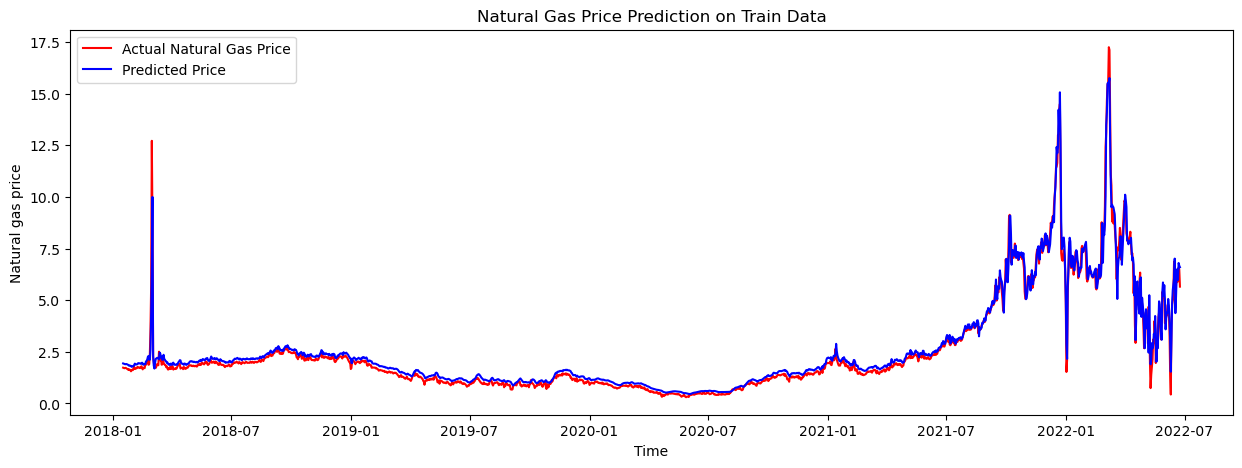

In [145]:
plt.figure(figsize = (15, 5))
plt.plot(train_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(train_compare['pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [146]:
### visulize result on test dataset

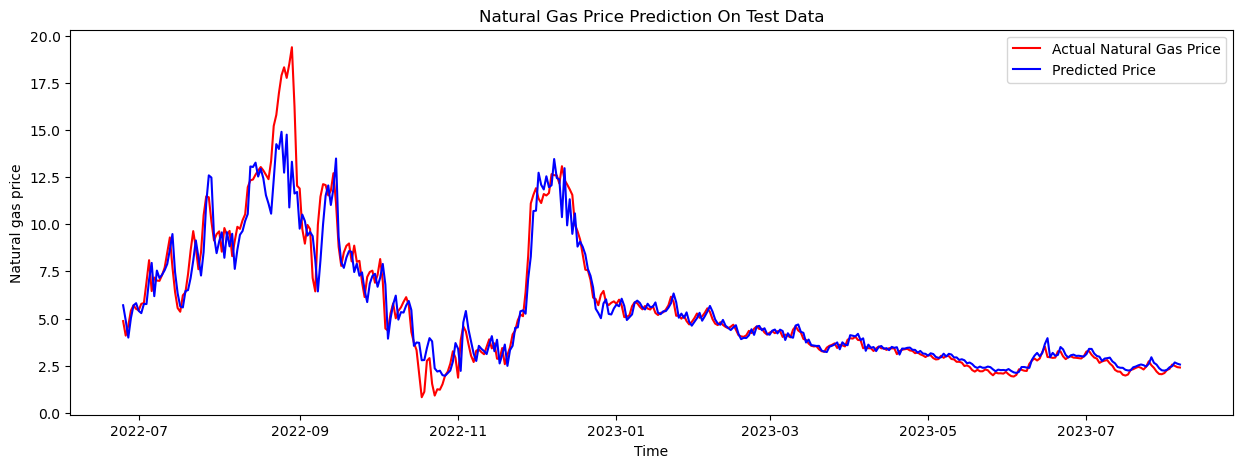

In [147]:
plt.figure(figsize = (15,5))
plt.plot(test_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(test_compare['pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction On Test Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

# forecast gas price from  2023-08-07 to 2023-08-13

In [148]:
def make_pred(lstm_model, slot, test):
    forecast = pd.DataFrame({'date': pd.date_range(start = '2023-08-07', end = '2023-08-13')}) # 2 March to 20 March 
    inputs = test[len(test) - slot: ].values
    # print(inputs)
    
    for i in range(slot, slot+len(forecast)): 
        # print(f"{i} th predict")
        inputs = inputs.T
        inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1)) 
    
        pred_price = lstm_model.predict(inputs[:,i-slot:i])
        # print(inputs[:,i-slot:i][0].ravel(), pred_price)
        inputs = np.append(inputs, pred_price)
        inputs = np.reshape(inputs, (inputs.shape[0], 1))
    
    # print(inputs)
    forecast['pred'] = inputs[-len(forecast):]
    forecast = forecast.set_index('date')
    return forecast

In [149]:
gas_model = lstm_model
gas_forecast = make_pred(gas_model, slot=15, test=test)

1/1 [==============================] - 0s 29ms/step


In [150]:
gas_forecast

,pred
date,
2023-08-07,2.536515
2023-08-08,2.668451
2023-08-09,2.827286
2023-08-10,3.051391
2023-08-11,3.350900
2023-08-12,3.749835
2023-08-13,4.284868


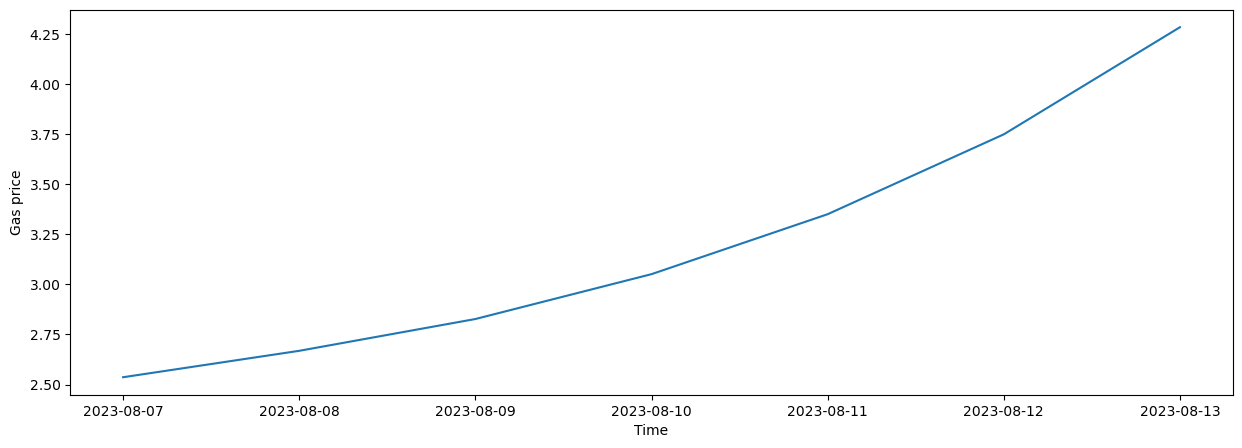

In [151]:
plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Gas price')
plt.plot(gas_forecast)

In [152]:
nextweek_gas_price = gas_forecast.pred.sum()

In [153]:
nextweek_gas_price

22.469245195388794

In [154]:
gas_value = nextweek_gas_price*33.33/100

In [155]:
gas_value

7.488999423623085

# electricity price prediction

In [156]:
## exploratory data analysis

In [157]:
elec.columns

Index(['Date', 'Daily average'], dtype='object')

In [158]:
data = elec.copy()
# Renaming columns
data = data.rename({'Date': 'date', 'Daily average': 'elec'}, axis = 1)

# Setting Date as index
data = data.set_index('date')

In [159]:
print(data.isnull().sum())

elec    0
dtype: int64


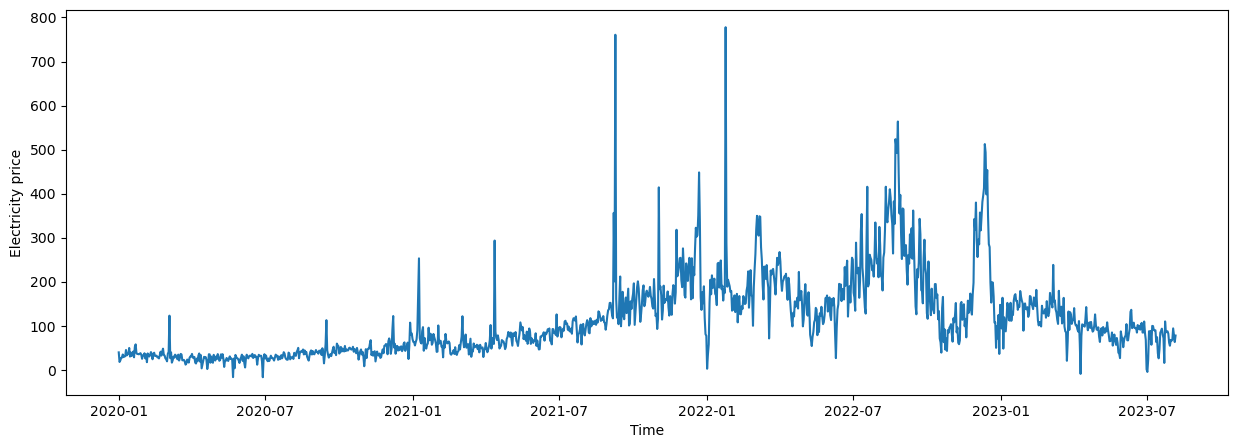

In [160]:
plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Electricity price')
plt.plot(data);

we can see that the electricity time series fluctuates greatly
for better modeling, we first remove some outliers and normalize the data using minmax

## Data Processing
1. using ffill method to fill the values which is less than 0 or greater than 98% percentile value 363.
2. normalize the series using minmax so that the values are beteween [-1, 1], to accelerate the model's convergence.

In [161]:
def fn(x):
    if x<0 or x > 363:
    # if x<0:
        return np.nan
    return x
data['elec_tf'] = data.elec.apply(lambda x: fn(x))
data = data.fillna(method='ffill')
maxx = 363
minn = 0
data['elec_norm'] = data.elec_tf.apply(lambda x: (maxx-x)/(maxx-minn))

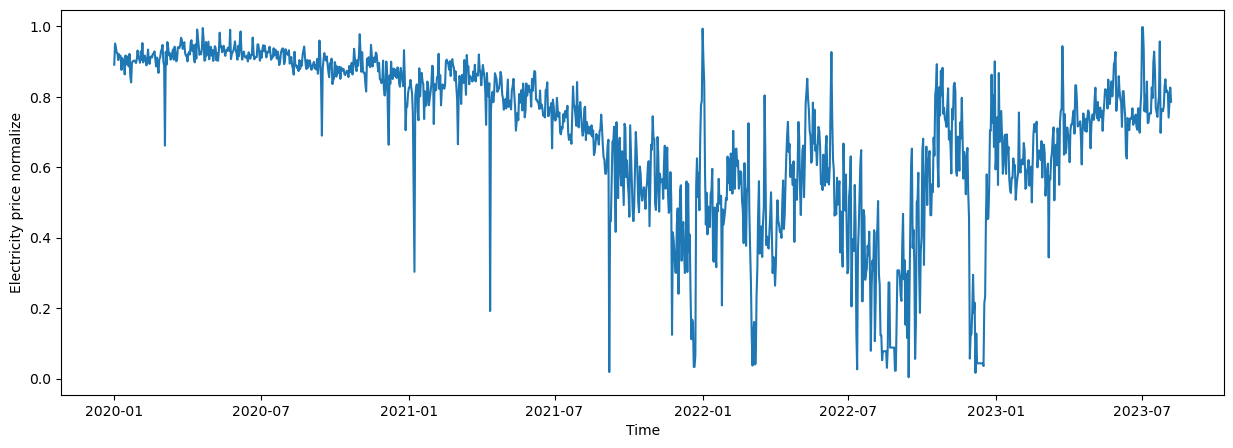

In [162]:
plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Electricity price normalize')
plt.plot(data['elec_norm']);

## build the lstm model

In [163]:
lstm_model = build_model(num_layers=3, slot=15,  dp1=0.2, dp2=0.2, unit1=80, unit2=50, unit3=8)
lstm_model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(learning_rate=0.003787))
# lstm_model.summary()

In [164]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 12)

train, test, x_train, y_train, x_test, y_test = build_data(data[['elec_norm']])
history = lstm_model.fit(x_train, y_train, epochs = 300, 
                         batch_size = 16, 
                         verbose = 1, shuffle = True, 
                         callbacks = [early_stopping])

Epoch 1/300
65/65 [==============================] - 15s 29ms/step - loss: 0.0810
Epoch 2/300
65/65 [==============================] - 3s 40ms/step - loss: 0.0337
Epoch 3/300
65/65 [==============================] - 2s 25ms/step - loss: 0.0294
Epoch 4/300
65/65 [==============================] - 2s 29ms/step - loss: 0.0294
Epoch 5/300
65/65 [==============================] - 2s 38ms/step - loss: 0.0240
Epoch 6/300
65/65 [==============================] - 2s 32ms/step - loss: 0.0229
Epoch 7/300
65/65 [==============================] - 2s 28ms/step - loss: 0.0215
Epoch 8/300
65/65 [==============================] - 2s 24ms/step - loss: 0.0218
Epoch 9/300
65/65 [==============================] - 2s 24ms/step - loss: 0.0192
Epoch 10/300
65/65 [==============================] - 1s 23ms/step - loss: 0.0169
Epoch 11/300
65/65 [==============================] - 1s 23ms/step - loss: 0.0187
Epoch 12/300
65/65 [==============================] - 5s 75ms/step - loss: 0.0171
Epoch 13/300
65/65 [====

### evalute the model

In [165]:
# predict on train set
slot = 15
yp_train = lstm_model.predict(x_train)
a = pd.DataFrame(yp_train)
a.rename(columns = {0: 'pred'}, inplace = True); 
a.index = train.iloc[slot:].index
train_compare = pd.concat([train.iloc[slot:], a], axis=1)

# predict on test set
pred = lstm_model.predict(x_test)
b = pd.DataFrame(pred)
b.rename(columns = {0: 'pred'}, inplace = True); 
b.index = test.index
test_compare = pd.concat([test, b], axis=1)

# calculate metrics: mse, r2 
mse_train = mean_squared_error(train_compare['elec_norm'], train_compare['pred'])
mse_test = mean_squared_error(test_compare['elec_norm'], test_compare['pred'])

r2_train = r2_score(train_compare['elec_norm'], train_compare['pred'])
r2_test = r2_score(test_compare['elec_norm'], test_compare['pred'])
print("Train Data:\nMSE: {}\nR Square: {}".format(mse_train, r2_train))
print("\nTest Data:\nMSE: {}\nR Square: {}".format(mse_test, r2_test))

9/9 [==============================] - 0s 13ms/step
Train Data:
MSE: 0.010365416402399462
R Square: 0.8042322657563991

Test Data:
MSE: 0.010148681634005136
R Square: 0.7200521841686871


### visulize result on train/test dataset

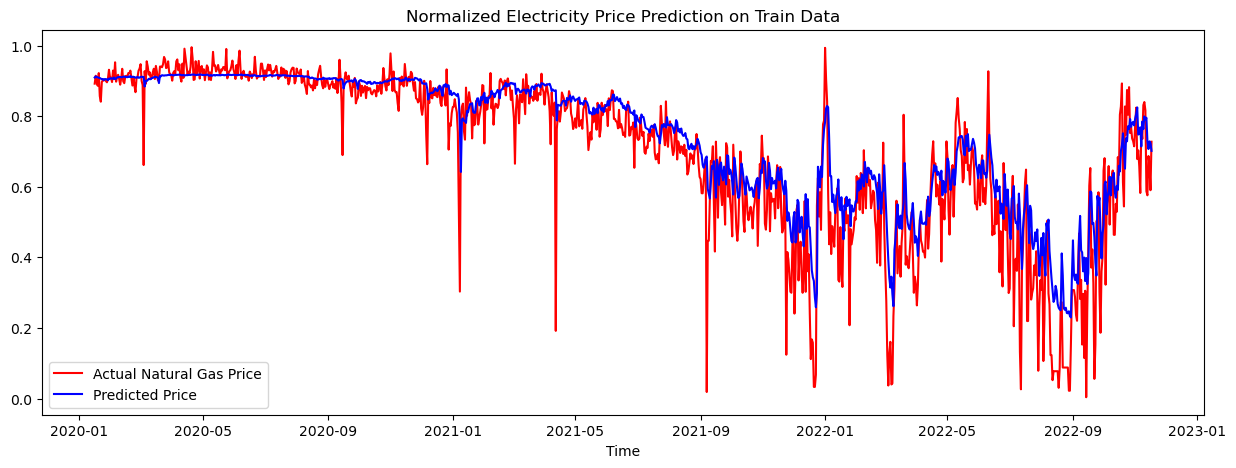

In [166]:
plt.figure(figsize = (15, 5))
plt.plot(train_compare['elec_norm'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(train_compare['pred'], color = 'blue', label = 'Predicted Price')
plt.title("Normalized Electricity Price Prediction on Train Data")
plt.xlabel('Time')
# plt.ylabel('Normalized Electricity price')
plt.legend(loc = 'best')
plt.show()

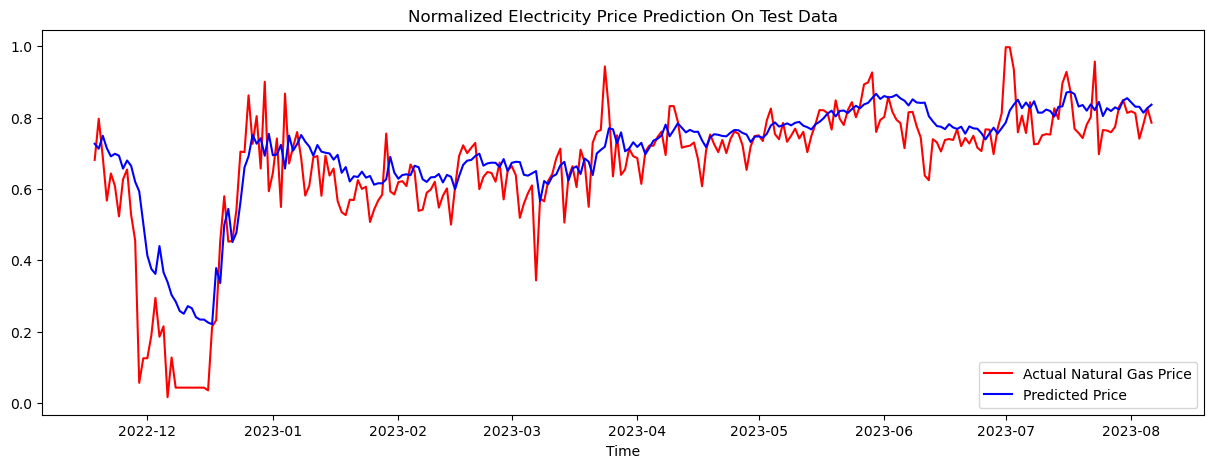

In [167]:
plt.figure(figsize = (15,5))
plt.plot(test_compare['elec_norm'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(test_compare['pred'], color = 'blue', label = 'Predicted Price')
plt.title("Normalized Electricity Price Prediction On Test Data")
plt.xlabel('Time')
# plt.ylabel('Normalized Electricity price')
plt.legend(loc = 'best')
plt.show()

## forcast elec price for the next week

In [168]:
elec_model = lstm_model
elec_forecast = make_pred(elec_model, slot=15, test=test)

1/1 [==============================] - 0s 32ms/step


In [169]:
elec_forecast

,pred
date,
2023-08-07,0.852829
2023-08-08,0.826516
2023-08-09,0.835329
2023-08-10,0.841029
2023-08-11,0.843943
2023-08-12,0.849723
2023-08-13,0.860573


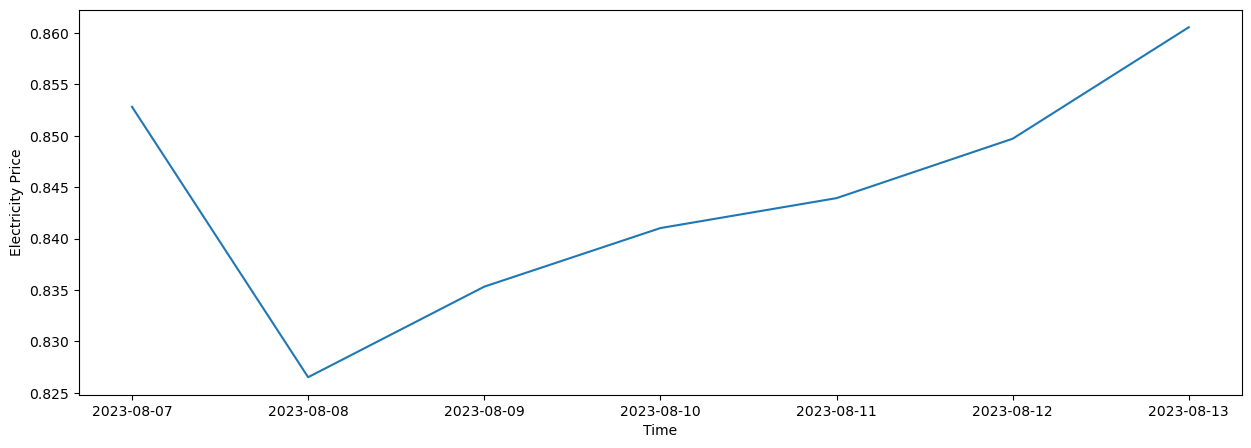

In [170]:
plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.plot(elec_forecast['pred']);

In [171]:
### transform the prediction back: minmax
maxx=363
minn=0
elec_forecast['pred_elec'] = elec_forecast['pred'].apply(lambda x: maxx - x*(maxx-minn)) 

In [172]:
elec_forecast

,pred,pred_elec
date,,
2023-08-07,0.852829,53.423080
2023-08-08,0.826516,62.974529
2023-08-09,0.835329,59.775423
2023-08-10,0.841029,57.706391
2023-08-11,0.843943,56.648626
2023-08-12,0.849723,54.550601
2023-08-13,0.860573,50.611982


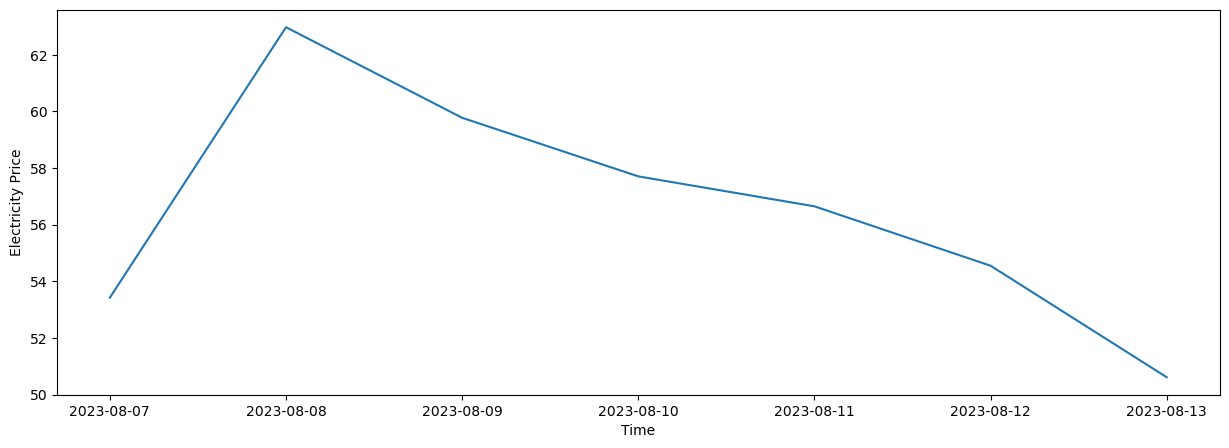

In [173]:
plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.plot(elec_forecast['pred_elec']);

In [174]:
nextweek_elec_price = elec_forecast.pred_elec.sum()

In [175]:
nextweek_elec_price

395.69063168764114

In [176]:
elec_value = nextweek_elec_price*8.07/100

In [177]:
elec_value

31.93223397719264

# weekly household spending

In [178]:
hs.head()

,Year,electricity,gas,total,weekly household spending
0,2002,6.47,6.56,13.03,589.0
1,2003,6.63,6.75,13.38,592.2
2,2004,6.73,7.08,13.81,596.8
3,2005,7.35,7.89,15.24,601.4
4,2006,8.29,9.05,17.34,593.8


In [179]:
# Renaming columns
hs = hs.rename({'weekly household spending': 'hs'}, axis = 1)

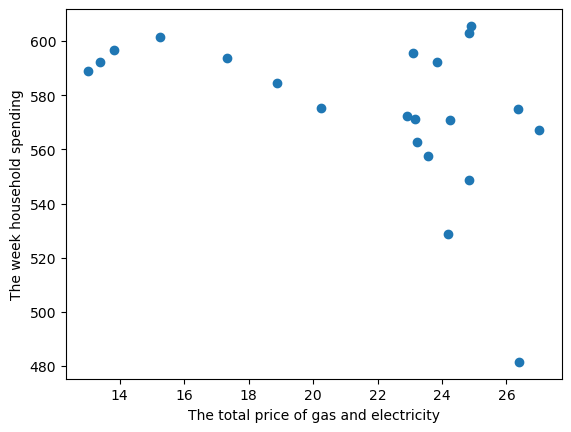

In [186]:
plt.scatter(hs.total, hs.hs)
plt.xlabel('The total price of gas and electricity')
plt.ylabel('The week household spending');

In [181]:
def model_fit(clf, norm=False, remove_outlier=True):
    
    if remove_outlier:
        minn = np.percentile(hs.hs, 5)
        maxx = np.percentile(hs.hs, 95)
        data = hs.query("hs >{} and hs < {}".format(minn, maxx))
    else:
        data = hs.copy()
        
    X = data[['gas', 'electricity','total']]
    # X = data[['total']]
    y = data['hs'].values
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    if norm:
        scalar = preprocessing.StandardScaler()
        scalar.fit(X_train)
        clf.fit(scalar.transform(X_train), y_train)
        s1 = clf.score(scalar.transform(X_train), y_train)
        s2 = clf.score(scalar.transform(X_test), y_test)
        print(s1, s2)
        return clf
    clf.fit(X_train, y_train)
    s1 = clf.score(X_train, y_train)
    s2 = clf.score(X_test, y_test)
    print(s1, s2)
    return clf

In [182]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing
clf = GradientBoostingRegressor(learning_rate=0.01)
clf = model_fit(clf, norm=False, remove_outlier=True)

0.8494554992444161 0.617300705586366


## make prediction of next week household spending

In [183]:
gas_value, elec_value, gas_value+elec_value

(7.488999423623085, 31.93223397719264, 39.42123340081572)

In [184]:
sample = pd.DataFrame(np.array([gas_value, elec_value, gas_value+elec_value ]).reshape(1,-1), columns=['gas', 'electricity', 'total'])
hs_predict = clf.predict(sample)

In [185]:
hs_predict

array([588.50078757])